In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
# from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint
from model import ODEBlock
import random

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = ("cpu")

In [3]:
# load the dataset
t = torch.load("./data/t.pth")
X = torch.load("./data/X.pth")
dX = torch.load("./data/dX.pth")

In [6]:
def getTrainingData():
    return t, X[range(0, X.shape[0], 50)]

# Training

In [9]:
t_eval, X_train = getTrainingData()
X_train.shape

torch.Size([10, 901, 38])

In [10]:
# parameters
num_traj = X_train.shape[0]
data_size = X_train.shape[1]
batch_time = 10
batch_size = 256
dim = X_train.shape[-1]

In [11]:
def get_batch(dataset, t):
    Batch_y0 = torch.Tensor()
    Batch_y = torch.Tensor()
    for ii in range(num_traj):
        true_y = dataset[ii]
        s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=True))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
        Batch_y0 = torch.cat((Batch_y0, batch_y0), dim=-2)
        Batch_y = torch.cat((Batch_y, batch_y), dim=-2)
    # return Batch_y0, batch_t, Batch_y
    return Batch_y0.to(device), batch_t.to(device), Batch_y.to(device)

In [12]:
batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)

In [13]:
batch_y0.shape, batch_y.shape, batch_t.shape

(torch.Size([2560, 38]), torch.Size([10, 2560, 38]), torch.Size([10]))

In [14]:
model = ODEBlock(dim,1000,dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
ITRs = 5000

In [15]:
Loss_train = []
Loss_test = []
for i in range(ITRs):
    batch_y0, batch_t, batch_y = get_batch(X_train, t_eval)
    optimizer.zero_grad()
    batch_y_hat = odeint(model, batch_y0, batch_t, atol=1e-6)
    loss = criterion(batch_y_hat, batch_y)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        Loss_train.append(loss.item())
        print(f'iteration: [{i+1}/{ITRs}], training loss: {loss.item():.6f}')


KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


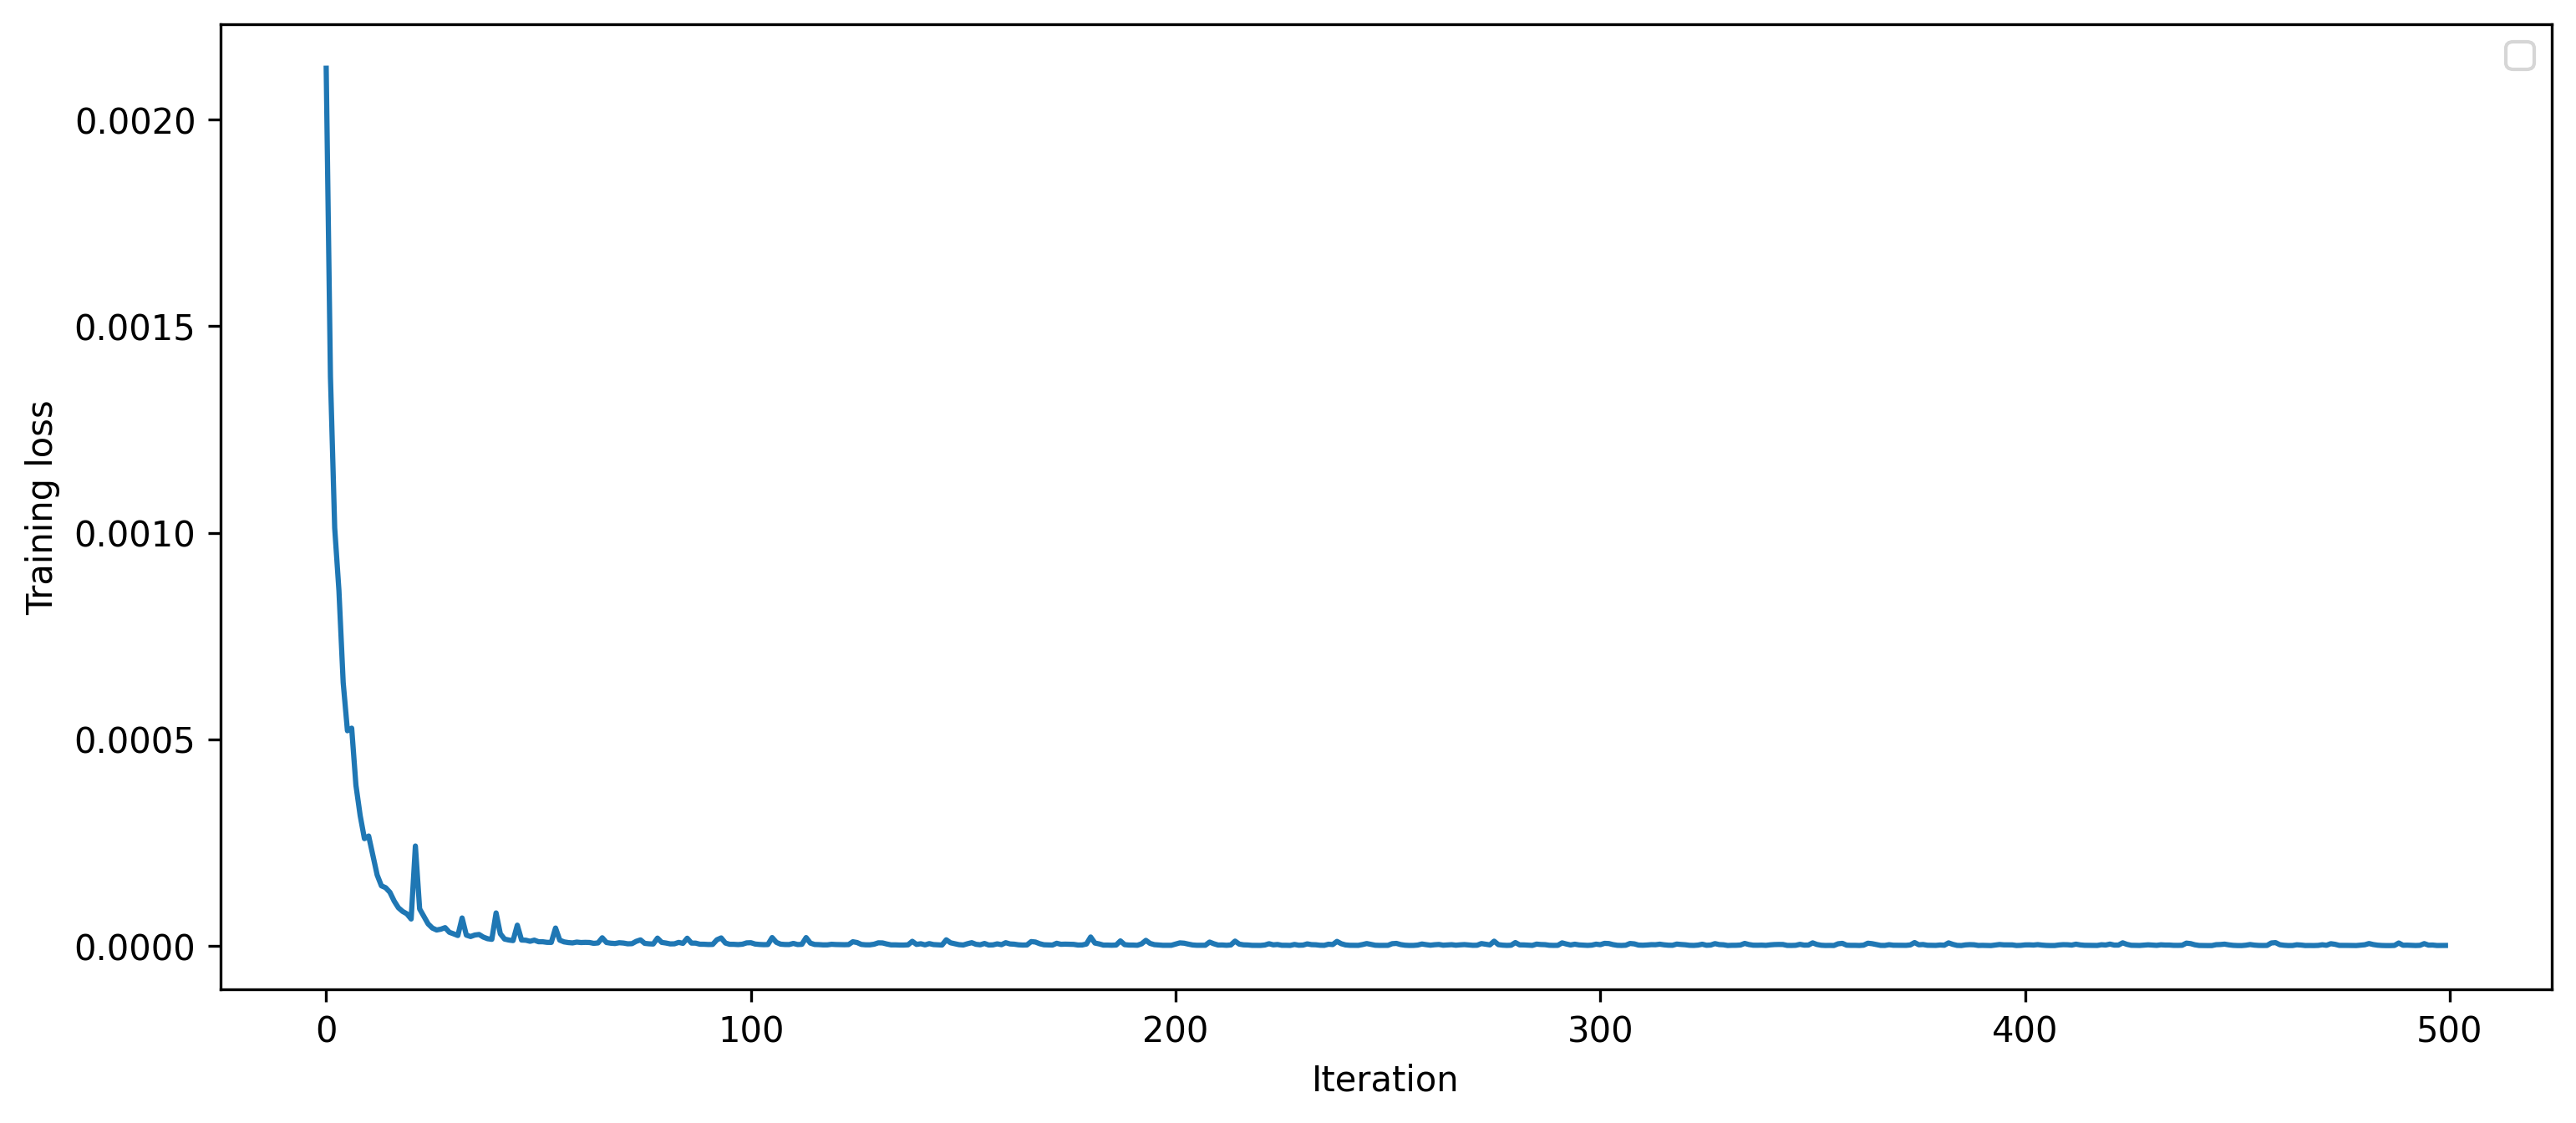

In [17]:
plt.figure(figsize=(12,5), dpi=300)
plt.plot(range(len(Loss_train)), Loss_train)
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend()

In [45]:
torch.save(model.state_dict(), './result/model/ODEBlock.pth')

# Evaluation

In [43]:
from scipy.integrate import solve_ivp
model.eval()
T = 6
FaultDuration=125
model.to("cpu")

t_eval, X_test = getTestData(FaultDuration=FaultDuration)
t_eval = t_eval - t_eval[0]
t_eval = t_eval[:T*100]
t_span = [t_eval[0],t_eval[-1]]
y0 = X_test[1,:]
y0

X_test_hat =odeint(model, y0, t_eval, method='dopri5').detach()

X_test = X_test[:T*100]

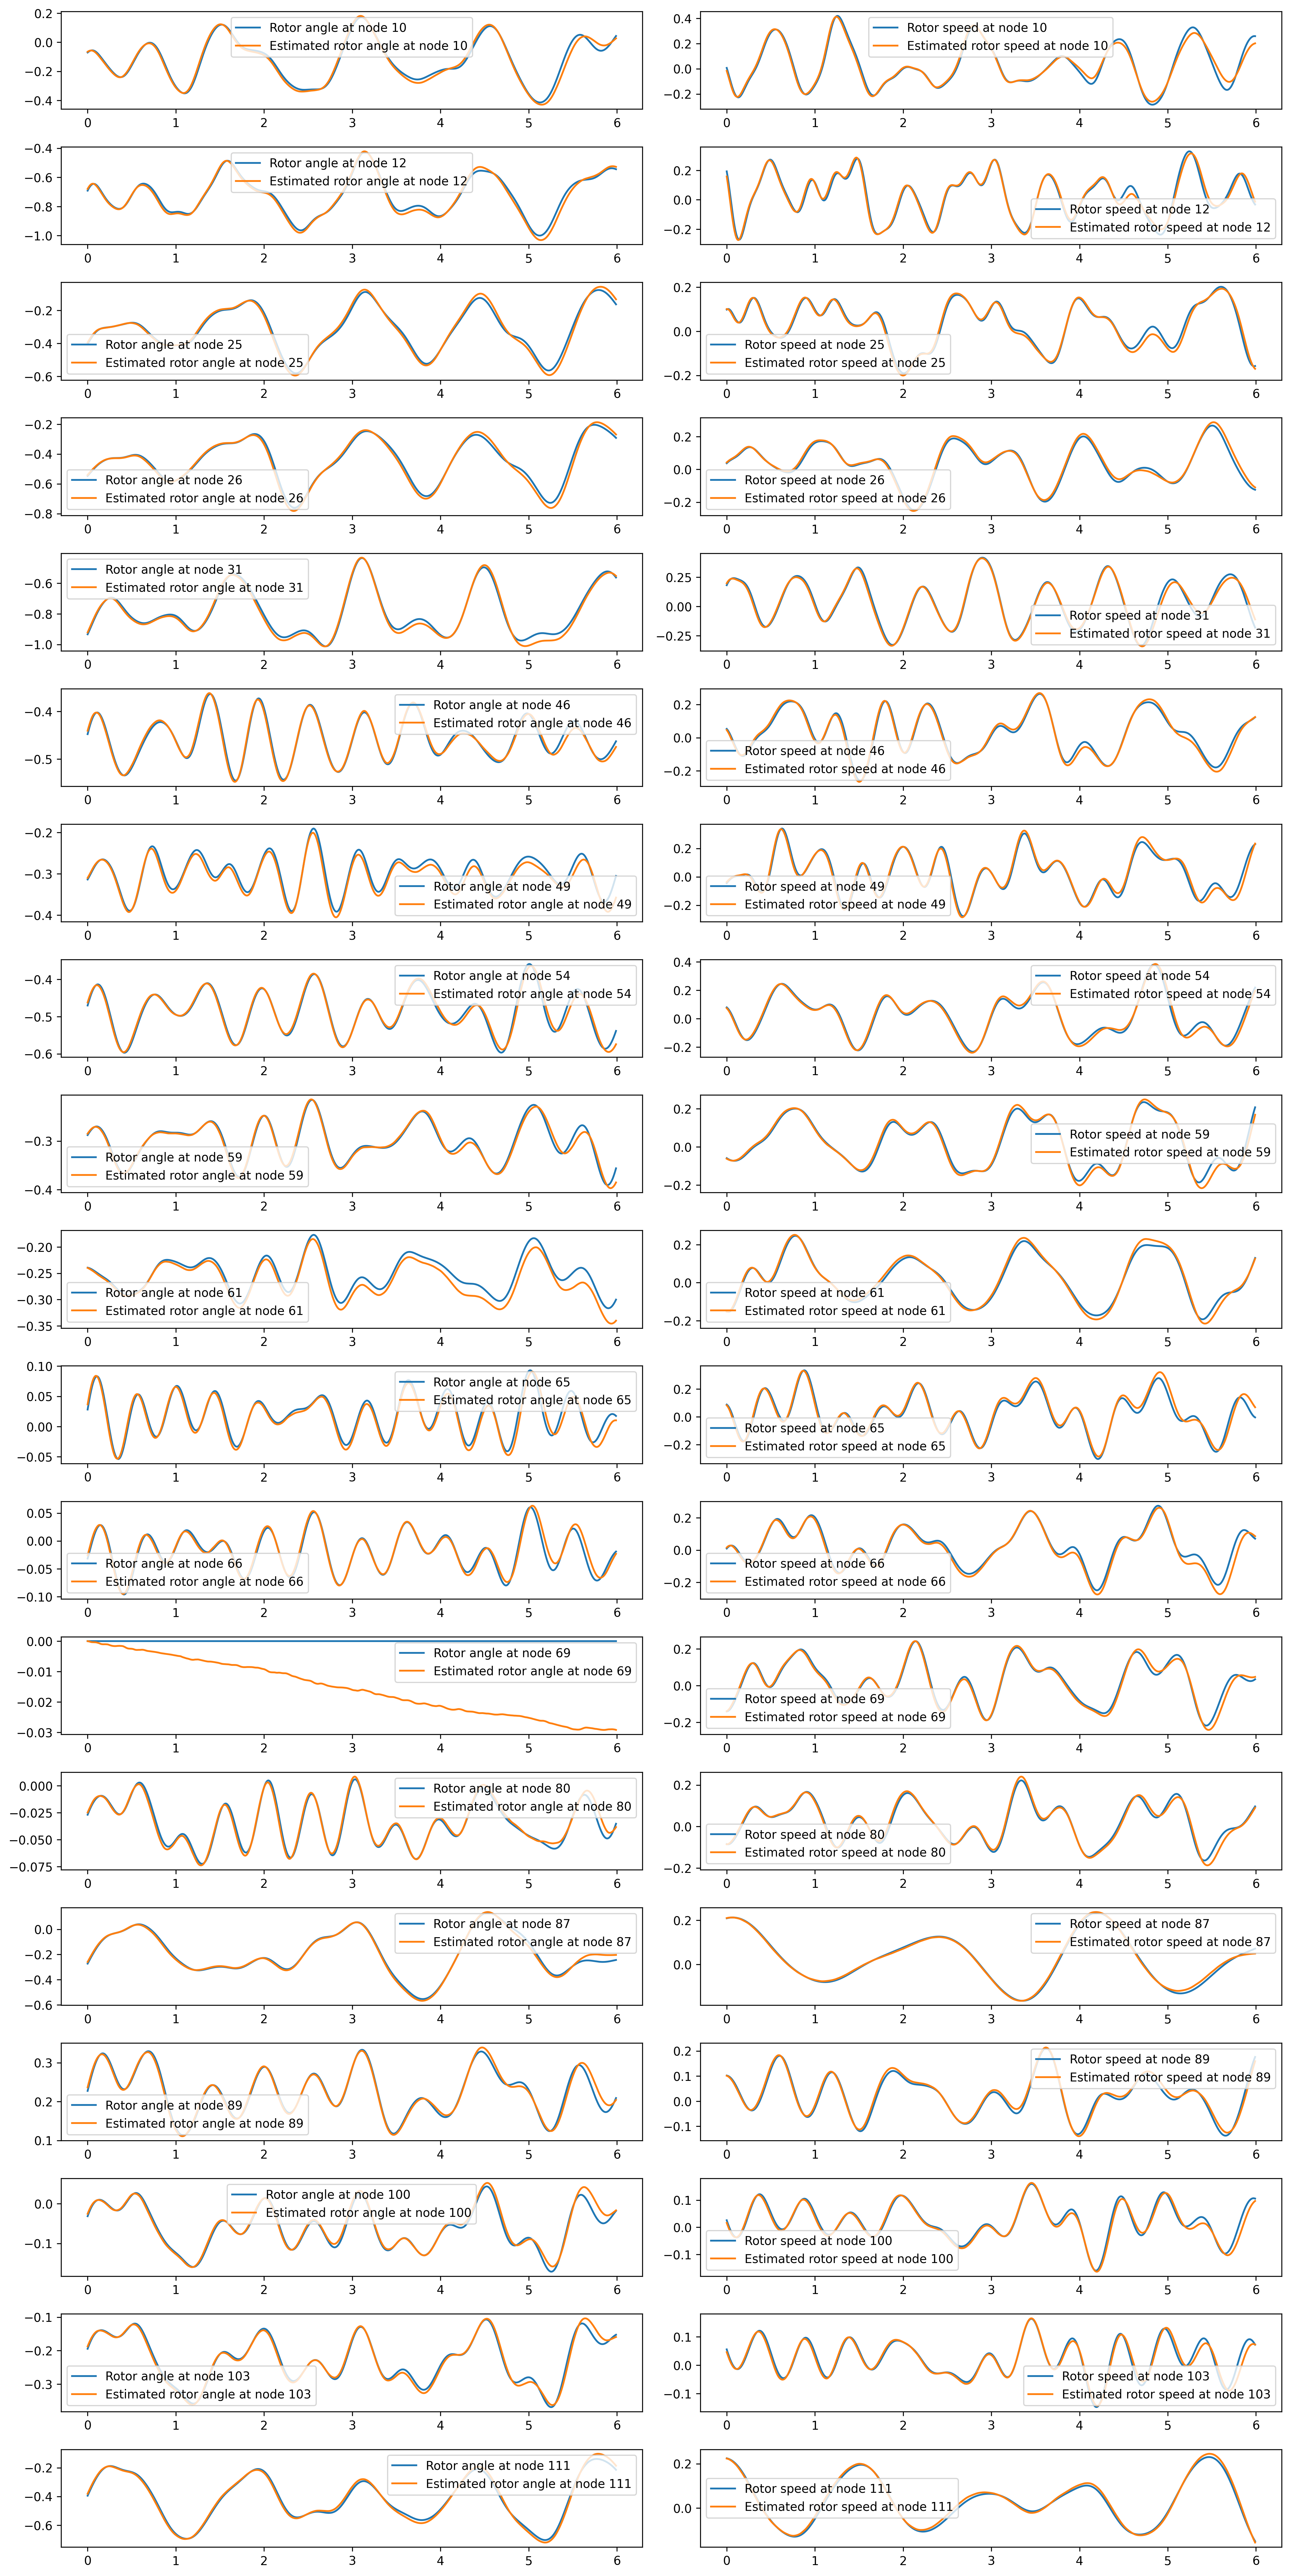

In [44]:
plt.figure(figsize=(15,30),dpi=300)
Generator_nodes = [10, 12, 25, 26, 31, 46, 49, 54, 59, 61, 65, 66, 69, 80, 87, 89, 100, 103, 111]
for i, node in enumerate(Generator_nodes):
    plt.subplot(19,2,2 * i + 1)
    plt.plot(t_eval, X_test[:,2 * i], label="Rotor angle at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i], label="Estimated rotor angle at node {}".format(node))
    plt.legend()
    plt.subplot(19,2,2 * i + 2)
    plt.plot(t_eval, X_test[:,2 * i + 1], label="Rotor speed at node {}".format(node))
    plt.plot(t_eval, X_test_hat[:,2 * i + 1], label="Estimated rotor speed at node {}".format(node))
    plt.legend()
plt.tight_layout()
plt.savefig("./result/test result/NeuralODE-FaultDuration{}".format(FaultDuration))